In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 # for cursor
import json # for opening credentials
import warnings
warnings.filterwarnings("ignore")

In [321]:
# for models and features
# !pip install ta # for Parabolic SAR (Stop and Reverse)
# !pip install catboost
import ta
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from collections import Counter

In [322]:
pd.set_option("display.max_columns", None)
pd.set_option('display.precision', 4)

# Download dataset

In [323]:
# загружаем ценовые данные для некоторого токена
# get credentials
with open('DB_creds.json', 'r') as f:
    config = json.load(f)

# Доступ к значениям
host = config['host']
port = config['port']
database = config['database']
user = config['user']
password = config['password']

# Параметры подключения
conn = psycopg2.connect(
    host=host, # house
    port=port, # room
    database=database,
    user=user,
    password=password
)

# Создаем курсор
cur = conn.cursor() # объект для взаимодействия с базой (пульт управления)

# Выполняем SQL-запрос
cur.execute(
"""
select * from okx_prices_btc
"""
)

# Получаем результаты
rows = cur.fetchall()

# Преобразуем в DataFrame (если хочешь)
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(rows, columns=columns)

# Закрываем подключение
cur.close()
conn.close()

In [324]:
df

,id,snapshot_timestamp,price,size,type,level,recorded_at
0,1,2025-05-12 17:25:27.356000+00:00,102826.7000000000,1.0856873800,bid,1,2025-05-12 17:25:27.457349+00:00
1,2,2025-05-12 17:25:27.356000+00:00,102826.0000000000,0.0583000000,bid,2,2025-05-12 17:25:27.457349+00:00
2,3,2025-05-12 17:25:27.356000+00:00,102825.5000000000,0.0578694600,bid,3,2025-05-12 17:25:27.457349+00:00
3,4,2025-05-12 17:25:27.356000+00:00,102825.2000000000,0.4278675700,bid,4,2025-05-12 17:25:27.457349+00:00
4,5,2025-05-12 17:25:27.356000+00:00,102825.1000000000,0.0360000000,bid,5,2025-05-12 17:25:27.457349+00:00
...,...,...,...,...,...,...,...
231045,231046,2025-05-20 17:59:01.501000+00:00,106232.5000000000,2.7924734700,ask,1,2025-05-20 17:59:03.238730+00:00
231046,231047,2025-05-20 17:59:01.501000+00:00,106232.6000000000,0.6970892600,ask,2,2025-05-20 17:59:03.238730+00:00
231047,231048,2025-05-20 17:59:01.501000+00:00,106232.8000000000,0.0010000000,ask,3,2025-05-20 17:59:03.238730+00:00
231048,231049,2025-05-20 17:59:01.501000+00:00,106233.2000000000,0.0010000000,ask,4,2025-05-20 17:59:03.238730+00:00


# Prepare initial dataset

In [325]:
df = df.sort_values(by=['id'])
df['price'] = df['price'].astype(float)
df['size'] = df['size'].astype(float)
#df.tail(50)

In [326]:
# Группируем по snapshot_timestamp
result = [] # Создаём пустой список — сюда будем складывать словари (одна строка стакана = один словарь).

for ts, group in df.groupby('snapshot_timestamp'): #Проходим по группам строк, где ts — это уникальное значение snapshot_timestamp, а group — подтаблица с ордерами на этот момент времени.
    row = {'dt': ts} #Создаём новую строку будущего датафрейма (словарь), с ключом 'dt', равным текущему snapshot_timestamp.

    # Выделяем заявки на покупку (bid) и продажу (ask), и сортируем их по уровню, чтобы bid_1 был ближе к рыночной цене, bid_2 — второй по глубине и т.д.
    bids = group[group['type'] == 'bid'].sort_values('level')
    asks = group[group['type'] == 'ask'].sort_values('level')

    # Проходим по строкам с бид-заявками. i — это уровень (1, 2, 3...).
    for i, (_, bid) in enumerate(bids.iterrows(), 1): # iterrows() -> (index, row)
        row[f'bid_{i}'] = bid['price']
        row[f'size_bid_{i}'] = bid['size']

    # Проходим по строкам с аск-заявками. i — это уровень (1, 2, 3...).
    for i, (_, ask) in enumerate(asks.iterrows(), 1):
        row[f'ask_{i}'] = ask['price']
        row[f'size_ask_{i}'] = ask['size']
    
    result.append(row)

# Соберем всё в датафрейм
book_df = pd.DataFrame(result).sort_values('dt')


In [327]:
book_df

,dt,bid_1,size_bid_1,bid_2,size_bid_2,bid_3,size_bid_3,bid_4,size_bid_4,bid_5,size_bid_5,ask_1,size_ask_1,ask_2,size_ask_2,ask_3,size_ask_3,ask_4,size_ask_4,ask_5,size_ask_5
0,2025-05-12 17:25:27.356000+00:00,102826.7,1.0857,102826.0,0.0583,102825.5,0.0579,102825.2,4.2787e-01,102825.1,3.6000e-02,102826.8,0.0141,102828.8,5.0000e-03,102830.0,2.9006e-04,102830.6,0.0002,102832.3,2.0000e-03
1,2025-05-12 17:25:37.356000+00:00,102838.5,0.4238,102838.1,0.0807,102838.0,0.0583,102837.6,2.5933e-02,102837.1,7.1931e-02,102838.6,0.5474,102840.0,2.0000e-05,102841.3,2.0000e-03,102842.9,0.0002,102843.2,5.0000e-03
2,2025-05-12 17:26:27.306000+00:00,102857.6,0.3566,102856.0,0.0896,102855.4,0.2036,102855.3,1.3651e-01,102854.0,5.8300e-02,102857.7,0.5882,102857.9,4.7124e-02,102858.0,5.8300e-02,102858.6,0.0050,102859.7,1.0000e-05
3,2025-05-12 17:26:37.306000+00:00,102872.9,0.4765,102872.0,0.0583,102871.7,0.0105,102870.8,3.1295e-02,102870.5,1.1960e-01,102873.0,0.6214,102873.3,3.0670e-04,102874.0,5.8300e-02,102875.0,0.0001,102875.1,2.0000e-03
4,2025-05-12 17:27:27.356000+00:00,102883.9,0.3719,102883.1,0.0237,102882.0,0.0583,102881.7,5.0000e-03,102880.3,9.0118e-02,102884.0,0.6206,102885.6,1.0000e-05,102885.7,5.4620e-05,102885.9,0.0384,102886.0,6.3300e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23100,2025-05-20 17:57:01.501000+00:00,106194.1,0.5849,106194.0,0.0049,106193.9,0.0071,106193.8,2.0070e-02,106193.7,2.6324e-02,106194.2,0.7427,106194.9,4.9388e-03,106196.0,1.8500e-02,106198.7,0.0234,106199.7,6.6796e-04
23101,2025-05-20 17:57:51.851000+00:00,106194.8,0.4360,106194.6,0.0020,106194.1,0.0020,106194.0,3.3691e-02,106193.9,7.0519e-03,106194.9,1.6574,106195.1,4.0127e-03,106195.4,5.4248e-02,106195.9,0.0627,106196.0,1.9500e-02
23102,2025-05-20 17:58:01.501000+00:00,106195.9,0.0467,106194.8,0.0049,106193.7,0.0543,106193.6,2.0000e-03,106192.8,3.7339e-02,106196.0,1.1365,106196.9,8.2471e-03,106197.0,1.0000e-03,106197.4,0.0274,106197.9,1.9000e-01
23103,2025-05-20 17:58:51.851000+00:00,106243.8,0.0436,106243.4,0.0299,106243.0,0.0299,106240.6,1.0000e-05,106240.0,1.0000e-05,106243.9,1.6508,106244.0,1.8500e-02,106244.1,2.7863e-01,106244.2,0.0010,106244.3,4.5404e-01


# EDA

In [312]:
book_df['mid_price_1'] = (book_df['bid_1'] + book_df['ask_1']) / 2

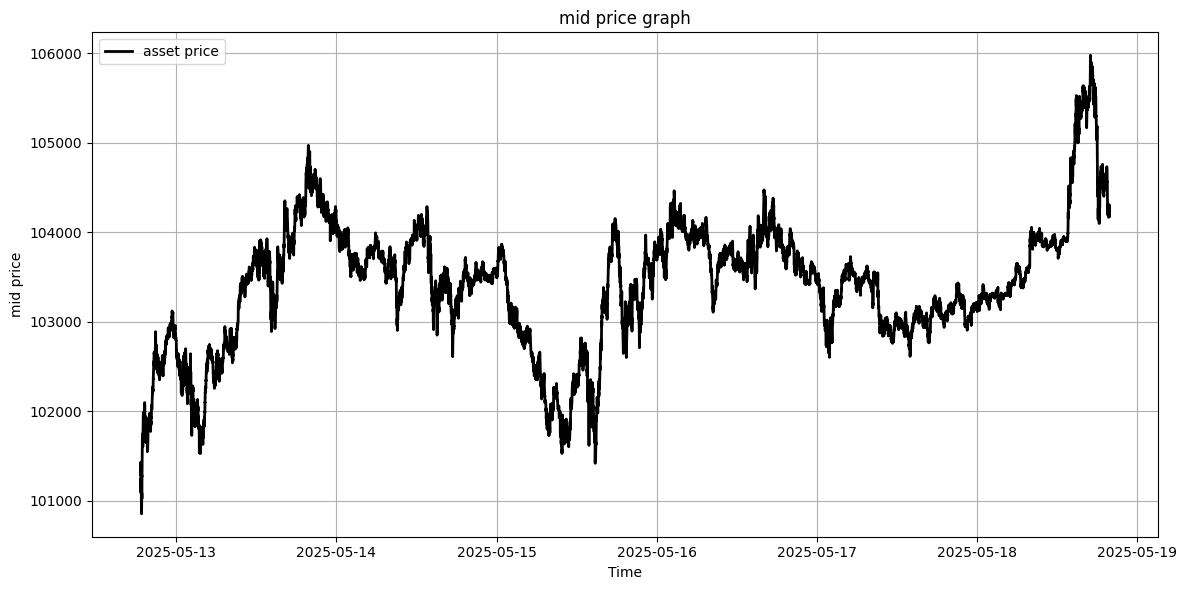

In [313]:
# graph with mid price
plt.figure(figsize=(12, 6))
plt.plot(book_df["dt"], book_df["mid_price_1"], label="asset price", linewidth=2, color = 'black')
plt.xlabel("Time")
plt.ylabel("mid price")
plt.title("mid price graph")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [314]:
book_df.describe()

,bid_1,size_bid_1,bid_2,size_bid_2,bid_3,size_bid_3,bid_4,size_bid_4,bid_5,size_bid_5,ask_1,size_ask_1,ask_2,size_ask_2,ask_3,size_ask_3,ask_4,size_ask_4,ask_5,size_ask_5,bid_ask_spread_1,bid_ask_spread_2,bid_ask_spread_3,bid_ask_spread_4,bid_ask_spread_5,mid_price_1,mid_price_2,mid_price_3,mid_price_4,mid_price_5,volume_1,volume_2,volume_3,volume_4,volume_5,ma_5,ema_5,volume_1_ma_5,ask_volume_1_ma_5,bid_volume_1_ma_5,ma_10,ema_10,volume_1_ma_10,ask_volume_1_ma_10,bid_volume_1_ma_10,ma_15,ema_15,volume_1_ma_15,ask_volume_1_ma_15,bid_volume_1_ma_15,ma_20,ema_20,volume_1_ma_20,ask_volume_1_ma_20,bid_volume_1_ma_20,ma_25,ema_25,volume_1_ma_25,ask_volume_1_ma_25,bid_volume_1_ma_25,ma_30,ema_30,volume_1_ma_30,ask_volume_1_ma_30,bid_volume_1_ma_30,ma_35,ema_35,volume_1_ma_35,ask_volume_1_ma_35,bid_volume_1_ma_35,ma_40,ema_40,volume_1_ma_40,ask_volume_1_ma_40,bid_volume_1_ma_40,ma_45,ema_45,volume_1_ma_45,ask_volume_1_ma_45,bid_volume_1_ma_45,ma_50,ema_50,volume_1_ma_50,ask_volume_1_ma_50,bid_volume_1_ma_50,bb_upper_20,bb_lower_20,bb_middle_20,macd,macd_signal,macd_diff,kdj_k,kdj_d,kdj_j,skdj_k,skdj_d,rsi,stochrsi_k,stochrsi_d,adx,di_pos,di_neg,obv,dma,trix_5,trix_10,trix_15,trix_20,trix_25,trix_30,trix_35,trix_40,trix_45,trix_50,vr,roc,mtm_5,mtm_10,mtm_15,mtm_20,mtm_25,mtm_30,mtm_35,mtm_40,mtm_45,mtm_50,psy_5,psy_10,psy_15,psy_20,psy_25,psy_30,psy_35,psy_40,psy_45,psy_50,y
count,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,1.7417e+04,1.7417e+04,1.7417e+04,1.7417e+04,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,1.7417e+04,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,1.7417e+04,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000
mean,103409.0760,7.0403e-01,103408.2533,7.0471e-02,103407.6414,7.4630e-02,103407.0612,7.1603e-02,103406.4764,6.0747e-02,103409.1776,7.6576e-01,103409.9771,8.3416e-02,103410.5676,8.0543e-02,103411.1371,7.2253e-02,103411.7135,7.3632e-02,0.1016,1.7238,2.9261,4.0759,5.2372,103409.1268,103409.1152,103409.1045,103409.0991,103409.0950,1.4698,1.5389e-01,1.5517e-01,1.4386e-01,1.3438e-01,103408.6287,103408.6304,1.4691,0.7652,0.7039,103408.2142,103408.2231,1.4689,0.7651,0.7038,103407.8035,103407.8326,1.4687,0.7649,0.7038,103407.4096,103407.4565,1.4689,0.7651,0.7038,103407.0304,103407.0905,1.4690,0.7652,0.7038,103406.6653,103406.7321,1.4690,0.7653,0.7038,103406.3170,103406.3800,1.4691,0.7653,0.7038,103405.9811,103406.0337,1.4691,0.7654,0.7038,103405.6453,103405.6930,1.4692,0.7654,0.7038,103405.3035,103405.3574,1.4692,0.7654,0.7038,103511.8241,103302.9951,103407.4096,1.0467,1.0158,0.0308,50.9288,50.9189,50.9499,50.9228,50.9111,50.4344,0.4988,0.4988,22.1626,50.2415,49.3731,2397.1100,1.1837,1.5995e-04,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,inf,0.0017,0.8339,1.6634,2.4448,

In [315]:
book_df.shape

(17417, 138)

In [316]:
book_df.columns

Index(['dt', 'bid_1', 'size_bid_1', 'bid_2', 'size_bid_2', 'bid_3',
       'size_bid_3', 'bid_4', 'size_bid_4', 'bid_5',
       ...
       'psy_10', 'psy_15', 'psy_20', 'psy_25', 'psy_30', 'psy_35', 'psy_40',
       'psy_45', 'psy_50', 'y'],
      dtype='object', length=138)

# Feature engineering

In [317]:
# spread
for window in [1, 2, 3, 4, 5]:
    book_df[f'bid_ask_spread_{window}'] = (book_df[f'ask_{window}'] - book_df[f'bid_{window}'])

# mid price
for window in [2, 3, 4, 5]:
    book_df[f'mid_price_{window}'] = (book_df[f'bid_{window}'] + book_df[f'ask_{window}']) / 2

# Volume
for window in [1, 2, 3, 4, 5]:
    book_df[f'volume_{window}'] = (book_df[f'size_bid_{window}'] + book_df[f'size_ask_{window}'])

# MA, EMA, volume с .shift(1)
for window in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    book_df[f'ma_{window}'] = book_df['mid_price_1'].rolling(window=window).mean().shift(1)
    book_df[f'ema_{window}'] = book_df['mid_price_1'].ewm(span=window, adjust=False).mean().shift(1)
    book_df[f'volume_1_ma_{window}'] = book_df['volume_1'].rolling(window=window).mean().shift(1)
    book_df[f'ask_volume_1_ma_{window}'] = book_df['size_ask_1'].rolling(window=window).mean().shift(1)
    book_df[f'bid_volume_1_ma_{window}'] = book_df['size_bid_1'].rolling(window=window).mean().shift(1)

# Bollinger Bands
ma20 = book_df['mid_price_1'].rolling(window=20).mean().shift(1)
std20 = book_df['mid_price_1'].rolling(window=20).std().shift(1)
book_df['bb_upper_20'] = ma20 + 2 * std20
book_df['bb_lower_20'] = ma20 - 2 * std20
book_df['bb_middle_20'] = ma20


# MACD
macd = ta.trend.MACD(close=book_df['mid_price_1'])
book_df['macd'] = macd.macd().shift(1)
book_df['macd_signal'] = macd.macd_signal().shift(1)
book_df['macd_diff'] = macd.macd_diff().shift(1)

# KDJ
low_min = book_df['bid_1'].rolling(window=9).min().shift(1)
high_max = book_df['ask_1'].rolling(window=9).max().shift(1)
rsv = ((book_df['mid_price_1'] - low_min) / (high_max - low_min + 1e-9)) * 100
book_df['kdj_k'] = rsv.ewm(com=2).mean().shift(1)
book_df['kdj_d'] = book_df['kdj_k'].ewm(com=2).mean().shift(1)
book_df['kdj_j'] = (3 * book_df['kdj_k'] - 2 * book_df['kdj_d']).shift(1)

# SKDJ
book_df['skdj_k'] = book_df['kdj_k'].ewm(span=3).mean().shift(1)
book_df['skdj_d'] = book_df['kdj_d'].ewm(span=3).mean().shift(1)

# RSI
book_df['rsi'] = ta.momentum.RSIIndicator(close=book_df['mid_price_1'], window=14).rsi().shift(1)

# Stochastic RSI
stoch_rsi = ta.momentum.StochRSIIndicator(close=book_df['mid_price_1'], window=14)
book_df['stochrsi_k'] = stoch_rsi.stochrsi_k().shift(1)
book_df['stochrsi_d'] = stoch_rsi.stochrsi_d().shift(1)

# DMI (ADX)
adx = ta.trend.ADXIndicator(high=book_df['ask_1'], low=book_df['bid_1'], close=book_df['mid_price_1'])
book_df['adx'] = adx.adx().shift(1)
book_df['di_pos'] = adx.adx_pos().shift(1)
book_df['di_neg'] = adx.adx_neg().shift(1)

# OBV
book_df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=book_df['mid_price_1'], volume=book_df['volume_1']).on_balance_volume().shift(1)

# DMA
book_df['dma'] = (book_df['mid_price_1'].rolling(window=10).mean() - book_df['mid_price_1'].rolling(window=25).mean()).shift(1)

# TRIX (NRIX)
for window in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    trix = ta.trend.TRIXIndicator(close=book_df['mid_price_1'], window=window)
    book_df[f'trix_{window}'] = trix.trix().shift(1)

# Volatility Ratio
diff = book_df['mid_price_1'].diff().shift(1)
up = diff.where(diff > 0, 0)
down = -diff.where(diff < 0, 0)
equal = diff.where(diff == 0, 0)
book_df['vr'] = (up.rolling(14).sum() + 0.5 * equal.rolling(14).sum()) / (
    down.rolling(14).sum() + 0.5 * equal.rolling(14).sum()
)

# ROC
book_df['roc'] = book_df['mid_price_1'].pct_change(periods=10).shift(1) * 100

# MTM
for window in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    book_df[f'mtm_{window}'] = (book_df['mid_price_1'] - book_df['mid_price_1'].shift(window)).shift(1)

# PSY
for window in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]: 
    positive = (book_df['mid_price_1'].diff().shift(1) > 0).astype(int)
    book_df[f'psy_{window}'] = positive.rolling(window).mean().shift(1) * 100

In [318]:
book_df.describe()

,bid_1,size_bid_1,bid_2,size_bid_2,bid_3,size_bid_3,bid_4,size_bid_4,bid_5,size_bid_5,ask_1,size_ask_1,ask_2,size_ask_2,ask_3,size_ask_3,ask_4,size_ask_4,ask_5,size_ask_5,bid_ask_spread_1,bid_ask_spread_2,bid_ask_spread_3,bid_ask_spread_4,bid_ask_spread_5,mid_price_1,mid_price_2,mid_price_3,mid_price_4,mid_price_5,volume_1,volume_2,volume_3,volume_4,volume_5,ma_5,ema_5,volume_1_ma_5,ask_volume_1_ma_5,bid_volume_1_ma_5,ma_10,ema_10,volume_1_ma_10,ask_volume_1_ma_10,bid_volume_1_ma_10,ma_15,ema_15,volume_1_ma_15,ask_volume_1_ma_15,bid_volume_1_ma_15,ma_20,ema_20,volume_1_ma_20,ask_volume_1_ma_20,bid_volume_1_ma_20,ma_25,ema_25,volume_1_ma_25,ask_volume_1_ma_25,bid_volume_1_ma_25,ma_30,ema_30,volume_1_ma_30,ask_volume_1_ma_30,bid_volume_1_ma_30,ma_35,ema_35,volume_1_ma_35,ask_volume_1_ma_35,bid_volume_1_ma_35,ma_40,ema_40,volume_1_ma_40,ask_volume_1_ma_40,bid_volume_1_ma_40,ma_45,ema_45,volume_1_ma_45,ask_volume_1_ma_45,bid_volume_1_ma_45,ma_50,ema_50,volume_1_ma_50,ask_volume_1_ma_50,bid_volume_1_ma_50,bb_upper_20,bb_lower_20,bb_middle_20,macd,macd_signal,macd_diff,kdj_k,kdj_d,kdj_j,skdj_k,skdj_d,rsi,stochrsi_k,stochrsi_d,adx,di_pos,di_neg,obv,dma,trix_5,trix_10,trix_15,trix_20,trix_25,trix_30,trix_35,trix_40,trix_45,trix_50,vr,roc,mtm_5,mtm_10,mtm_15,mtm_20,mtm_25,mtm_30,mtm_35,mtm_40,mtm_45,mtm_50,psy_5,psy_10,psy_15,psy_20,psy_25,psy_30,psy_35,psy_40,psy_45,psy_50,y
count,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,1.7417e+04,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,17417.0000,1.7417e+04,1.7417e+04,1.7417e+04,1.7417e+04,17412.0000,17416.0000,17412.0000,17412.0000,17412.0000,17407.0000,17416.0000,17407.0000,17407.0000,17407.0000,17402.0000,17416.0000,17402.0000,17402.0000,17402.0000,17397.0000,17416.0000,17397.0000,17397.0000,17397.0000,17392.0000,17416.0000,17392.0000,17392.0000,17392.0000,17387.0000,17416.0000,17387.0000,17387.0000,17387.0000,17382.0000,17416.0000,17382.0000,17382.0000,17382.0000,17377.0000,17416.0000,17377.0000,17377.0000,17377.0000,17372.0000,17416.0000,17372.0000,17372.0000,17372.0000,17367.0000,17416.0000,17367.0000,17367.0000,17367.0000,17397.0000,17397.0000,17397.0000,17391.0000,17383.0000,17383.0000,17407.0000,17406.0000,17405.0000,17406.0000,17405.0000,17403.0000,17388.0000,17386.0000,17416.0000,17416.0000,17416.0000,17416.0000,17392.0000,1.7403e+04,17388.0000,17373.0000,17358.0000,17343.0000,17328.0000,17313.0000,17298.0000,17283.0000,17268.0000,1.7403e+04,17406.0000,17411.0000,17406.0000,17401.0000,17396.0000,17391.0000,17386.0000,17381.0000,17376.0000,17371.0000,17366.0000,17412.0000,17407.0000,17402.0000,17397.0000,17392.0000,17387.0000,17382.0000,17377.0000,17372.0000,17367.0000,17417.0000
mean,103409.0760,7.0403e-01,103408.2533,7.0471e-02,103407.6414,7.4630e-02,103407.0612,7.1603e-02,103406.4764,6.0747e-02,103409.1776,7.6576e-01,103409.9771,8.3416e-02,103410.5676,8.0543e-02,103411.1371,7.2253e-02,103411.7135,7.3632e-02,0.1016,1.7238,2.9261,4.0759,5.2372,103409.1268,103409.1152,103409.1045,103409.0991,103409.0950,1.4698,1.5389e-01,1.5517e-01,1.4386e-01,1.3438e-01,103409.2273,103408.7454,1.4697,0.7658,0.7038,103409.4040,103408.3230,1.4698,0.7659,0.7039,103409.5936,103407.9004,1.4699,0.7659,0.7039,103409.7940,103407.4750,1.4699,0.7659,0.7040,103410.0095,103407.0454,1.4700,0.7660,0.7040,103410.2245,103406.6111,1.4701,0.7661,0.7040,103410.4267,103406.1726,1.4702,0.7661,0.7041,103410.6085,103405.7302,1.4704,0.7662,0.7042,103410.7694,103405.2846,1.4705,0.7663,0.7042,103410.9102,103404.8362,1.4706,0.7664,0.7043,103514.1076,103305.4804,103409.7940,1.2409,1.2503,-0.0083,50.7305,50.7263,50.7473,50.7286,50.7224,50.4504,0.4986,0.4986,22.1089,50.2139,49.3142,2406.0015,1.3215,1.6661e-04,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,inf,0.0017,0.8280,1.6899,2.5473

# Final preparations

In [292]:
cnt_nan = 0
for col in book_df.columns:
    potential_nan = 50
    if book_df[col].isna().sum() > potential_nan:
        print(col, ':', book_df[col].isna().sum())
        cnt_nan +=1

if cnt_nan == 0:
    print(f'no more than regular number {potential_nan} of features')

trix_20 : 59
trix_25 : 74
trix_30 : 89
trix_35 : 104
trix_40 : 119
trix_45 : 134
trix_50 : 149
mtm_50 : 51


In [297]:
# create target
minutes_to_predict = 4
threshold = 0.0005
book_df['y'] = (book_df['mid_price_1'].shift(-minutes_to_predict) > book_df['mid_price_1'] * (1 + threshold)).astype(int) # 0.05% = 0.0005

In [299]:
book_df['y'].mean()

0.17094552285535378

In [300]:
book_df = book_df.dropna().reset_index(drop=True)

In [301]:
book_df.shape

(17417, 138)

In [302]:
# split samples
split_idx = int(len(book_df) * 0.8)
train_df = book_df.iloc[:split_idx]
test_df = book_df.iloc[split_idx:]

print('----------------------------')
print('shape of train:', train_df.shape)
print('----------------------------')
print('shape of test:', test_df.shape)
print('----------------------------')

----------------------------
shape of train: (13933, 138)
----------------------------
shape of test: (3484, 138)
----------------------------


In [303]:
target_col = 'y'
drop_cols = ['dt', 'y']
feature_cols = [col for col in book_df.columns if col not in drop_cols] # drop columns which we are not gonna use

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# Modelling

In [304]:
# if there is disbalance
class_counts_dsb = Counter(y_train)
total_counts_dsb = sum(class_counts_dsb.values())
class_weights = {
    0: total_counts_dsb / (2 * class_counts_dsb[0]),
    1: total_counts_dsb / (2 * class_counts_dsb[1])
}

In [305]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    eval_metric='AUC',
    class_weights=class_weights,
    verbose=200,
    random_seed=42
)

In [306]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

0:	test: 0.4641129	best: 0.4641129 (0)	total: 19.4ms	remaining: 19.4s
200:	test: 0.5373229	best: 0.5880212 (16)	total: 2.55s	remaining: 10.2s
400:	test: 0.5260711	best: 0.5880212 (16)	total: 5.09s	remaining: 7.6s
600:	test: 0.5163132	best: 0.5880212 (16)	total: 7.55s	remaining: 5.01s
800:	test: 0.5105850	best: 0.5880212 (16)	total: 9.99s	remaining: 2.48s
999:	test: 0.5183878	best: 0.5880212 (16)	total: 12.6s	remaining: 0us

bestTest = 0.588021203
bestIteration = 16

Shrink model to first 17 iterations.
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3079
           1       0.25      0.07      0.11       405

    accuracy                           0.87      3484
   macro avg       0.57      0.52      0.52      3484
weighted avg       0.81      0.87      0.83      3484



In [307]:
# Простейший бейзлайн: смотрим, была ли цена > на 0.5% в прошлые minutes_to_predict минут
#threshold - we defined it before
baseline = (test_df['mid_price_1'] > test_df['mid_price_1'].shift(minutes_to_predict) * (1 + threshold)).astype(int)

# Предсказания CatBoost
y_true = y_test.values
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_catboost = model.predict(X_test)

threshold_for_predict = 0.35
y_pred_thresholded = (y_pred_proba > threshold_for_predict).astype(int)

# Метрики
print("Baseline AUC:", roc_auc_score(y_true, baseline))
print("CatBoost AUC:", roc_auc_score(y_true, y_pred_proba))


Baseline AUC: 0.5445915982020778
CatBoost AUC: 0.5880212029719446


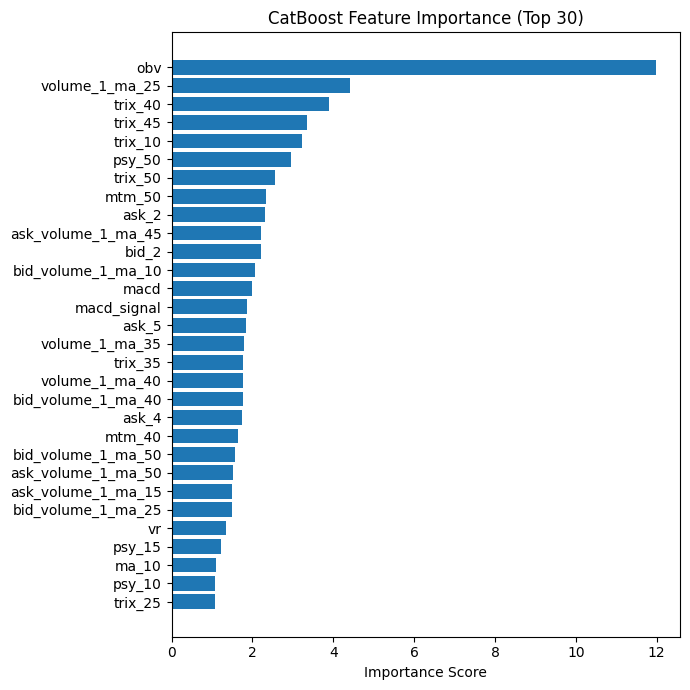

In [308]:
# Получаем важности и создаём DataFrame
feature_importance = model.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
})

# Сортируем по убыванию важности
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Визуализация
top_30 = importance_df.sort_values(by='importance', ascending=False).head(30)
plt.figure(figsize=(7, 7))
plt.barh(top_30['feature'], top_30['importance'])
plt.gca().invert_yaxis()  # Самые важные сверху
plt.title("CatBoost Feature Importance (Top 30)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

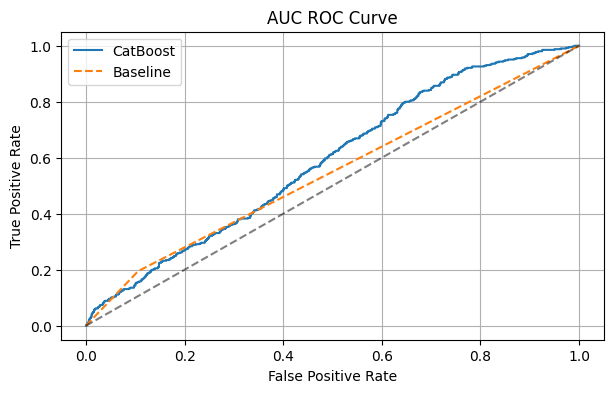

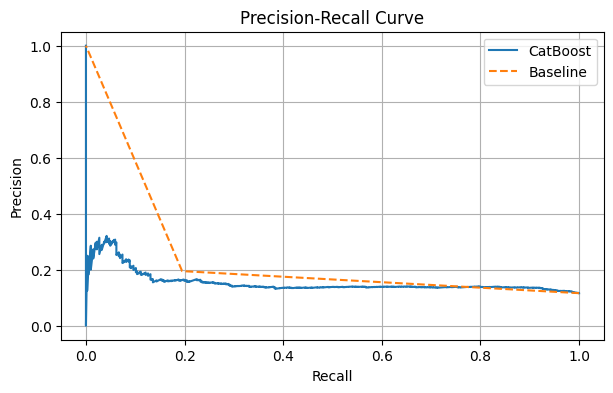

Baseline AP: 0.13161968638045046
CatBoost AP: 0.1549645155713711


In [309]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
fpr_base, tpr_base, _ = roc_curve(y_true, baseline)

plt.figure(figsize=(7, 4))
plt.plot(fpr, tpr, label='CatBoost')
plt.plot(fpr_base, tpr_base, linestyle='--', label='Baseline')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('AUC ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
precision_base, recall_base, _ = precision_recall_curve(y_true, baseline)

plt.figure(figsize=(7, 4))
plt.plot(recall, precision, label='CatBoost')
plt.plot(recall_base, precision_base, linestyle='--', label='Baseline')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Average Precision Score
print("Baseline AP:", average_precision_score(y_true, baseline))
print("CatBoost AP:", average_precision_score(y_true, y_pred_proba))


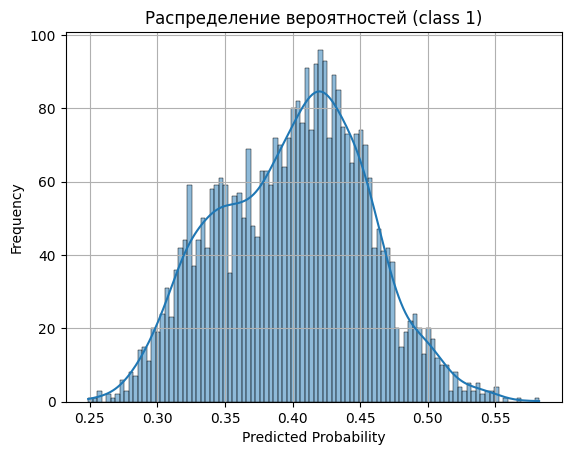

In [310]:
sns.histplot(y_pred_proba, bins=100, kde=True)
plt.title("Распределение вероятностей (class 1)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()